In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import scipy as sc
import plotly
import random
import datetime
from datetime import datetime, date
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
%matplotlib inline

In [9]:
df = pd.read_csv('C:/Games/Test/SB/consumer_data.csv', encoding = 'cp1251', parse_dates = ['InvoiceDate'])

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Проведем кластеризацию пользователей методом rfm анализа.

Для начала, удалим всем пользователей с несуществующим ID и установим некоторую сегодняшнюю дату.

In [12]:
df.drop(df[df['CustomerID'].isna()].index, inplace = True)
df = df.reset_index()

In [16]:
now = pd.Timestamp('2011-12-10')

0

Выведем в отдельный столбец, сколько всего поступало денег с каждой покупки

In [17]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['item_sum'] = df['Quantity'] * df['UnitPrice']

Посчитаем, сколько прошло времени с момента последней покупки каждого пользователя, как много покупал каждый пользователь, и сколько всего денег потратил каждый пользователь.

In [18]:
df_rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days,
                                       'InvoiceNo': 'nunique',
                                       'item_sum': sum})

df_rfm.rename(columns = {
    'InvoiceDate': 'days_delta',
    'InvoiceNo': 'cnt_orders',
    'item_sum': 'total_sum'
}, inplace = True)

array([[<AxesSubplot:title={'center':'days_delta'}>,
        <AxesSubplot:title={'center':'cnt_orders'}>],
       [<AxesSubplot:title={'center':'total_sum'}>, <AxesSubplot:>]],
      dtype=object)

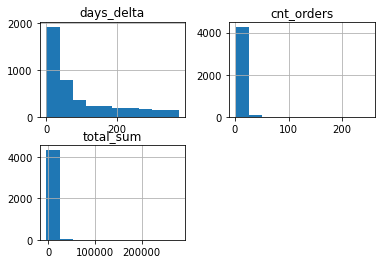

In [19]:
df_rfm.hist()

На графиках видно, что все 3 графика имеют логнормальное распределение.

Ниже приведем несколько примеров для понятия, какой из методов разделения данных луччше использовать.

In [20]:
np.random.seed(10)
test = pd.DataFrame({'normal': np.random.normal(10,3,1000),
                     'lognormal': np.random.lognormal(10, 3, 1000)})

<AxesSubplot:>

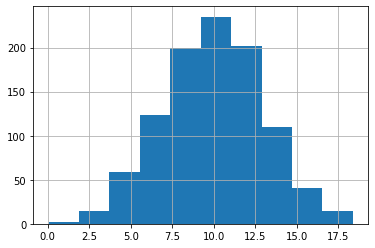

In [21]:
np.log(test['lognormal']).hist()

In [22]:
norm_cut = pd.cut(test['normal'], 8)
lognorm_cut = pd.cut(test['lognormal'], 8)

In [23]:
norm_cut.value_counts()

(9.213, 11.42]      308
(7.007, 9.213]      239
(11.42, 13.626]     212
(4.8, 7.007]        117
(13.626, 15.833]     67
(2.593, 4.8]         28
(15.833, 18.04]      24
(0.369, 2.593]        5
Name: normal, dtype: int64

In [24]:
lognorm_cut.value_counts()

(-95964.257, 11995664.13]       981
(11995664.13, 23991327.212]      12
(23991327.212, 35986990.294]      4
(35986990.294, 47982653.376]      1
(59978316.458, 71973979.54]       1
(83969642.622, 95965305.704]      1
(47982653.376, 59978316.458]      0
(71973979.54, 83969642.622]       0
Name: lognormal, dtype: int64

Видно, что для нормального распределения cut отработал хорошо, в то время как для логнормального рспределения почти все данные попали в один кластер, что не предоставляет никакого интереса для анализа данных.<br>

Попробуем выбросить экстремальные значения

In [25]:
lognorm2 = test[test['lognormal'] < test['lognormal'].quantile(0.95)]['lognormal']

In [26]:
lognorm2_cut = pd.cut(lognorm2, 8)
lognorm2_cut.value_counts()

(-2680.394, 335181.349]       822
(335181.349, 670361.65]        53
(670361.65, 1005541.951]       31
(1340722.252, 1675902.553]     12
(1005541.951, 1340722.252]      9
(1675902.553, 2011082.854]      8
(2346263.155, 2681443.456]      8
(2011082.854, 2346263.155]      7
Name: lognormal, dtype: int64

Разбиение по кластерам прошло чуть лучше, однако, большая часть данных все равно сконцентрирована в одном кластере.

Воспользуемся разбиением qcut

In [27]:
test['lognormal_quantiles'] = pd.qcut(test['lognormal'], 8)

In [28]:
test['lognormal_quantiles'].value_counts()

(1.0470000000000002, 645.367]    125
(645.367, 3104.284]              125
(3104.284, 8557.424]             125
(8557.424, 22367.106]            125
(22367.106, 59419.662]           125
(59419.662, 166566.3]            125
(166566.3, 673580.266]           125
(673580.266, 95965305.704]       125
Name: lognormal_quantiles, dtype: int64

Все данные разбились равномерно по кластерам, что позволяет подробно анализировать каждую группу

Оценим rfm разбивку для наших пользователей

In [29]:
df_rfm['bin_recency'] = pd.qcut(df_rfm['days_delta'], 5, labels = [i for i in range(1,6)])

bins = [0.999, df_rfm['cnt_orders'].quantile(1 / 5), df_rfm['cnt_orders'].quantile(2 / 5),
        df_rfm['cnt_orders'].quantile(3 / 5), df_rfm['cnt_orders'].quantile(4 / 5),
        df_rfm['cnt_orders'].quantile(5 / 5)]

df_rfm['bin_frequency'] = pd.cut(df_rfm['cnt_orders'], bins = bins, labels = [i for i in range(1,6)])

df_rfm['bin_monetary'] = pd.qcut(df_rfm['total_sum'], 5, labels = [i for i in range(1,6)])

In [30]:
df_rfm

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary
CustomerID,,,,,,
12346,325,2,0.00,5,2,1
12347,2,7,4310.00,1,4,5
12348,75,4,1797.24,4,3,4
12349,18,1,1757.55,2,1,4
12350,310,1,334.40,5,1,2
...,...,...,...,...,...,...
18280,277,1,180.60,5,1,1
18281,180,1,80.82,5,1,1
18282,7,3,176.60,1,3,1


По данной таблице уже  можно анализировать каждого пользователя, но она не информативна. Преобразуем ее в понятный для чтения и анализа вид

In [31]:
pd.pivot_table(df_rfm, index = ['bin_recency', 'bin_frequency'], columns = 'bin_monetary',
               values = 'total_sum', aggfunc = 'count').fillna(0)

bin_monetary                 1    2   3   4    5
bin_recency bin_frequency                       
1           1               29   20   9   1    1
            2               18   37  27  17    3
            3                8   24  62  55   15
            4                2    3  24  94   63
            5                1    0   2  57  332
2           1               78   51  19   3    0
            2               25   50  51  10    3
            3                2   26  85  67   18
            4                0    1  28  95   53
            5                0    0   5  39  151
3           1              115   96  36  14    1
            2               31   57  63  21    5
            3               12   24  74  70   18
            4                1    6  25  74   43
            5                0    0   4  26   68
4           1              127   93  47  16    8
            2               33   59  80  32    4
            3               12   38  76  67   19
            4                4    5  23  41   29
            5                0    1   2  13   21
5           1              311  167  51  16    4
            2               55   76  41  18    1
            3               10   36  25  18    6
            4                1    2  13   7    4
            5                0    2   2   3    5

Здесь:<br>
bin_recency 1 - пользователь недавно совершал первую покупку, 5 - очень давно.<br>
bin_frequency 1 - пользователь очень редко совершает покупки, 5 - очень часто<br>
bin_monetary 1 - пользователь тратит мало денег на покупки, 5 - очень много

Теперь можно оценивать, сколько пользователей и в какой группе находятся. В дальнейшем, можно легко ориентироваться, на каких пользователей стоит тратить больше усилий для удержания и привлечения внимания, а каким стоит изредка напоминать воспользоваться магазином, например, идущими в текущий момент скидками

Сделаем более удобное чтение разбиения

In [32]:
df_rfm['segment_concat'] = df_rfm[['bin_recency', 'bin_frequency', 'bin_monetary']]\
        .apply(lambda x: str(x['bin_recency']) + str(x['bin_frequency'])+ str(x['bin_monetary']), axis = 'columns')

In [33]:
df_rfm

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segment_concat
CustomerID,,,,,,,
12346,325,2,0.00,5,2,1,521
12347,2,7,4310.00,1,4,5,145
12348,75,4,1797.24,4,3,4,434
12349,18,1,1757.55,2,1,4,214
12350,310,1,334.40,5,1,2,512
...,...,...,...,...,...,...,...
18280,277,1,180.60,5,1,1,511
18281,180,1,80.82,5,1,1,511
18282,7,3,176.60,1,3,1,131


Далее, например, можно посчитать расстояние между покупками у пользователей в секундах

In [34]:
def neighbors(iterable):
    iterable = iter(iterable)
    previous = None
    currency = iterable.__next__()
    try:
        while True:
            _next = iterable.__next__()
            yield(previous, currency, _next)
            previous, currency = currency, _next
    except StopIteration:
            yield(previous, currency, None)


In [35]:
def calc_timedelta(dates):
    timedelta_list = []
    for i, j, k in neighbors(dates):
        if k is None:
            pass
        else:
            delta = (k - j).total_seconds()
            timedelta_list.append(delta)
    return timedelta_list

Сгруппируем данные для передачи в функцию по списку дат покупок

In [36]:
df_user_invoices = df.groupby(['CustomerID', 'InvoiceNo']).agg({'InvoiceDate': 'max'})\
                   .reset_index()[['CustomerID', 'InvoiceDate']].groupby('CustomerID').agg({'InvoiceDate': list})

In [37]:
df_user_invoices

,InvoiceDate
CustomerID,
12346,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]"
12347,"[2010-12-07 14:57:00, 2011-01-26 14:30:00, 201..."
12348,"[2010-12-16 19:09:00, 2011-01-25 10:42:00, 201..."
12349,[2011-11-21 09:51:00]
12350,[2011-02-02 16:01:00]
...,...
18280,[2011-03-07 09:52:00]
18281,[2011-06-12 10:53:00]
18282,"[2011-08-05 13:35:00, 2011-12-02 11:43:00, 201..."


Далее, отсортируем полученные данные по времени покупки

In [38]:
df_user_invoices['InvoiceDate'] = df_user_invoices['InvoiceDate'].sort_values()

In [39]:
df_user_invoices.head()

,InvoiceDate
CustomerID,
12346,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]"
12347,"[2010-12-07 14:57:00, 2011-01-26 14:30:00, 201..."
12348,"[2010-12-16 19:09:00, 2011-01-25 10:42:00, 201..."
12349,[2011-11-21 09:51:00]
12350,[2011-02-02 16:01:00]


In [40]:
df_user_invoices['InvoiceDate'] = df_user_invoices['InvoiceDate'].apply(lambda x: sorted(x))

In [41]:
df_user_invoices['InvoiceDate'].iloc[1]

[Timestamp('2010-12-07 14:57:00'),
 Timestamp('2011-01-26 14:30:00'),
 Timestamp('2011-04-07 10:43:00'),
 Timestamp('2011-06-09 13:01:00'),
 Timestamp('2011-08-02 08:48:00'),
 Timestamp('2011-10-31 12:25:00'),
 Timestamp('2011-12-07 15:52:00')]

In [42]:
calc_timedelta(df_user_invoices['InvoiceDate'].iloc[0])

[960.0]

In [43]:
df_user_invoices['timedeltas'] = df_user_invoices['InvoiceDate'].apply(calc_timedelta)


Посчитаем среднее время между покупками, а также заполним отсутствующие данные как максимальное расстояние до последней покупки (это пользователи с одной покупкой)

In [44]:
df_user_invoices['mean_timedeltas'] = df_user_invoices['timedeltas'].apply(lambda x: np.mean(x))
df_user_invoices['mean_timedeltas'].fillna(df_user_invoices['mean_timedeltas'].max(), inplace = True)

C:\Games\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


И разобьем по категориям

In [45]:
bins = [-1, df_user_invoices['mean_timedeltas'].quantile(1 / 5), df_user_invoices['mean_timedeltas'].quantile(2 / 5),
        df_user_invoices['mean_timedeltas'].quantile(3 / 5),
        df_user_invoices['mean_timedeltas'].quantile(3 / 5) + df_user_invoices['mean_timedeltas'].quantile(3 / 5) - df_user_invoices['mean_timedeltas'].quantile(1 / 5),
       df_user_invoices['mean_timedeltas'].quantile(5 / 5)]

df_user_invoices['rfn_mean_timedeltas'] = pd.cut(df_user_invoices['mean_timedeltas'], bins = bins, labels = [i for i in range(1,6)])



In [46]:
df_user_invoices.rfn_mean_timedeltas.value_counts()

5    1447
1     875
2     874
3     874
4     302
Name: rfn_mean_timedeltas, dtype: int64

Соединим эти данные с разбитым датафреймом

In [47]:
df_rfm2 = pd.merge(df_rfm, df_user_invoices['rfn_mean_timedeltas'], how = 'left', left_index = True, right_index = True)

In [48]:
df_rfm2.head()

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segment_concat,rfn_mean_timedeltas
CustomerID,,,,,,,,
12346,325,2,0.00,5,2,1,521,1
12347,2,7,4310.00,1,4,5,145,3
12348,75,4,1797.24,4,3,4,434,3
12349,18,1,1757.55,2,1,4,214,5
12350,310,1,334.40,5,1,2,512,5


Теперь вернемся к изначальному датафрейму и попробуем произвести кластеризацию пользователей по видам покупок

In [56]:
df_user_product = df.groupby(['CustomerID', 'StockCode']).agg({'Quantity': 'sum'}).unstack(1).fillna(0)

Воспользуемся для понижением размерности методом TSNE, с сохранением информации

In [63]:
tsne = TSNE()
transformed = tsne.fit_transform(df_user_product)

<AxesSubplot:>

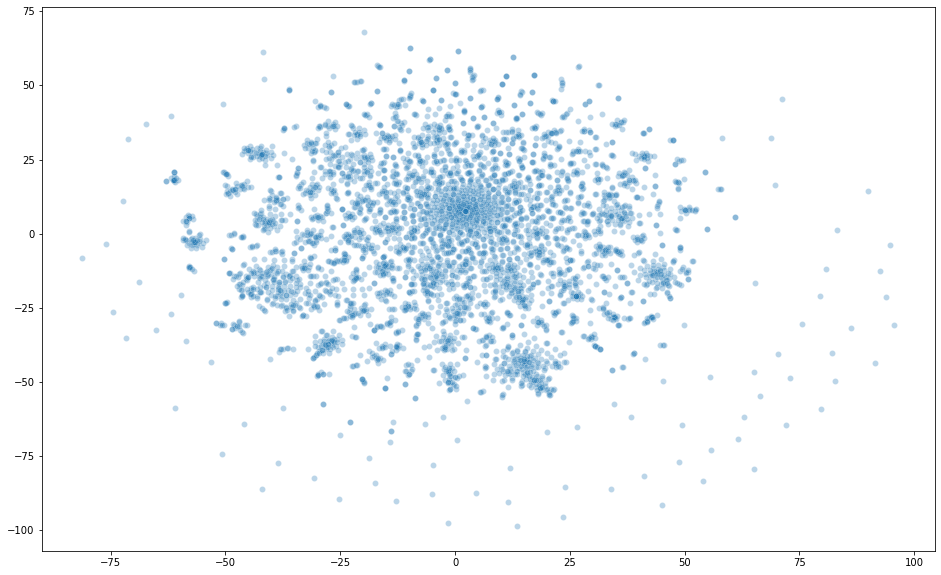

In [71]:
plt.figure(figsize = (16,10))
sns.scatterplot(x = transformed[:, 0], y = transformed[:, 1],
               palette = sns.color_palette('hls', 10),
               legend = 'full', alpha = 0.3)

Можно увидеть, что помимо большого центрального кластера, есть много небольших кластеров поодаль, а также выбросы<br>
Наши пользователи по покупкам значительно различаются

Попробуем отнормировать наши данные

In [72]:
x_user_products_tfidf = TfidfTransformer().fit_transform(df_user_product.values)

In [73]:
x_user_products_tfidf_transformed = tsne.fit_transform(x_user_products_tfidf.toarray())

<AxesSubplot:>

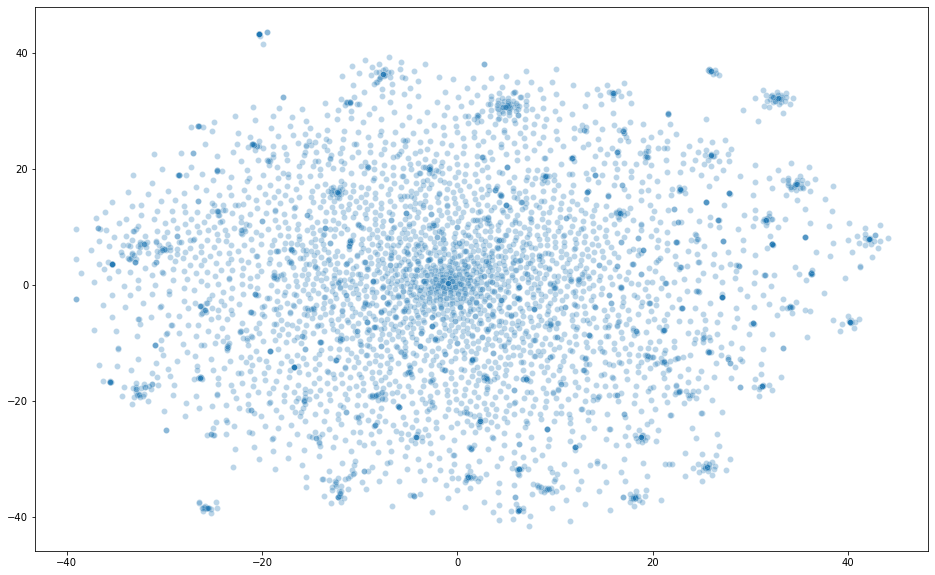

In [74]:
plt.figure(figsize = (16,10))
sns.scatterplot(x = x_user_products_tfidf_transformed[:, 0], y = x_user_products_tfidf_transformed[:, 1],
               palette = sns.color_palette('hls', 10),
               legend = 'full', alpha = 0.3)

Здесь можно более явно различить группы кластеров

In [75]:
products = df['Description'].unique()

array([[<AxesSubplot:title={'center':'Description'}>]], dtype=object)

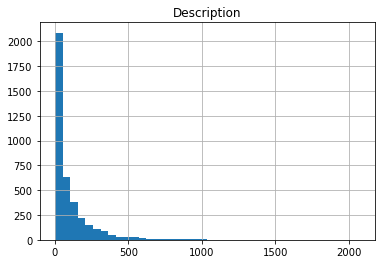

In [78]:
df.groupby('Description').agg({'Description': 'count'}).hist(bins = 40)

In [79]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(products)

In [81]:
x.shape

(3896, 2039)

In [83]:
model = DBSCAN()
clusters = model.fit_predict(x.toarray())

In [84]:
np.unique(clusters)

array([-1,  0,  1,  2,  3], dtype=int64)

In [88]:
products[clusters == 1]

array(['NUMBER TILE COTTAGE GARDEN 8', 'NUMBER TILE COTTAGE GARDEN 9',
       'NUMBER TILE COTTAGE GARDEN 1', 'NUMBER TILE COTTAGE GARDEN 0 ',
       'NUMBER TILE COTTAGE GARDEN 6', 'NUMBER TILE COTTAGE GARDEN 2',
       'NUMBER TILE COTTAGE GARDEN 7', 'NUMBER TILE COTTAGE GARDEN 5',
       'NUMBER TILE COTTAGE GARDEN 4', 'NUMBER TILE COTTAGE GARDEN 3 '],
      dtype=object)

In [118]:
model = AgglomerativeClustering(n_clusters = 713, affinity = 'cosine', linkage = 'complete')
preds = model.fit_predict(x.toarray())

In [119]:
np.unique(preds)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [122]:
products[preds == 71]

array(['BROCADE RING PURSE ', 'RED RETROSPOT PURSE ',
       'BLUE POLKADOT PURSE ', 'BLUE PATCH PURSE PINK HEART',
       'DENIM PATCH PURSE PINK BUTTERFLY',
       'BLUE ROSE PATCH PURSE PINK BUTTERFL', 'RED PURSE WITH PINK HEART',
       'BLUE FLOWER DES PURSE'], dtype=object)